# Load data

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
df = pd.read_csv('ECE 143.csv')
df.set_index(["State"], inplace=True)
# drop outlier
df = df.drop("California") 
df = df.drop("District of Columbia") # advanced degree outlier

<AxesSubplot:xlabel='sale', ylabel='State'>

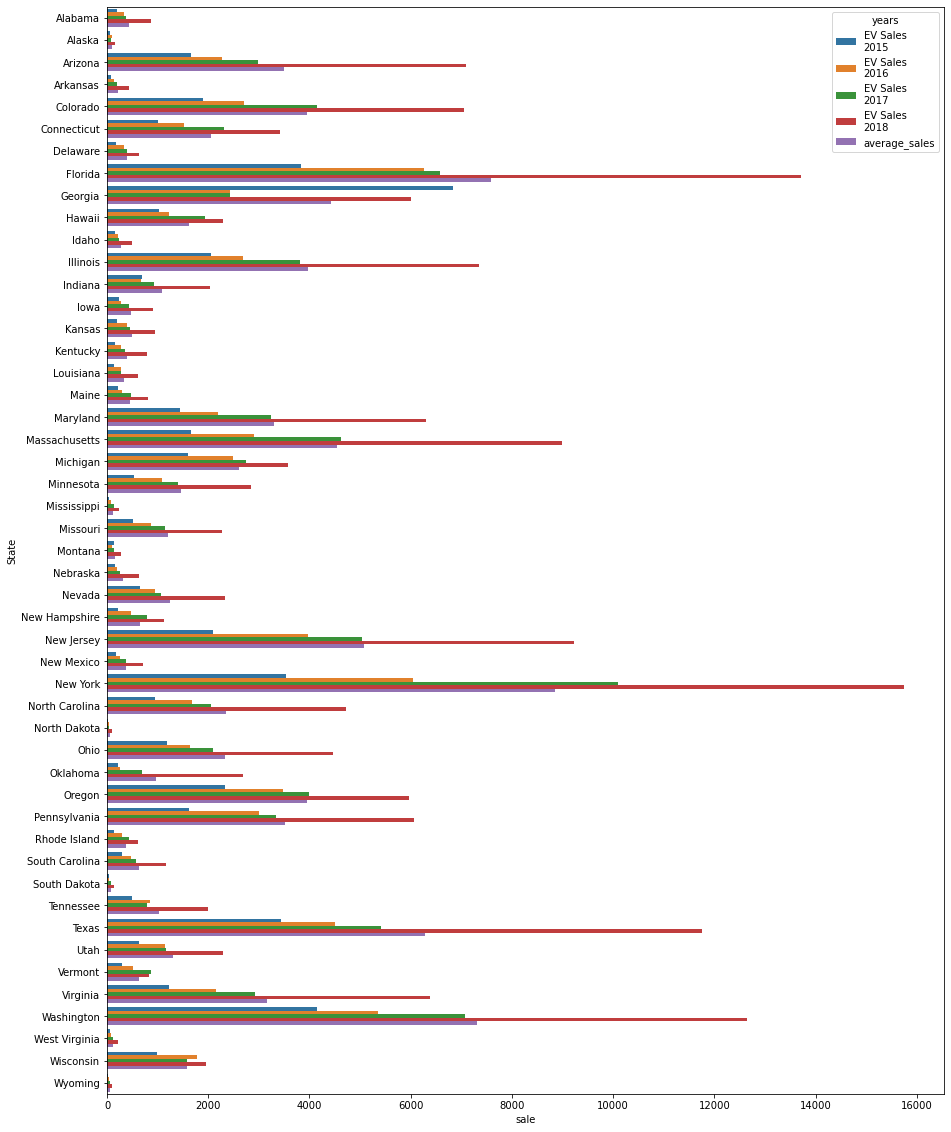

In [105]:
# Compute average sales and add to df
if 'average_sales' not in df:
    df.insert(5, 'average_sales', df.iloc[:,1:5].mean(axis=1).to_frame())
    df['average_sales'] = df['average_sales'].astype(int)
# Plot state sales data
sales_data = df.iloc[:,1:6]
sales_data['State'] = sales_data.index.get_level_values('State')
x=pd.melt(sales_data,id_vars="State", var_name="years", value_name="sale")
y=x.groupby(["State","years"]).sum()
y['State'] = y.index.get_level_values('State')
y['years'] = y.index.get_level_values('years')
plt.figure(figsize=(15,20))
sns.barplot(x='sale', y='State', hue="years",data=y)

# Linear regression

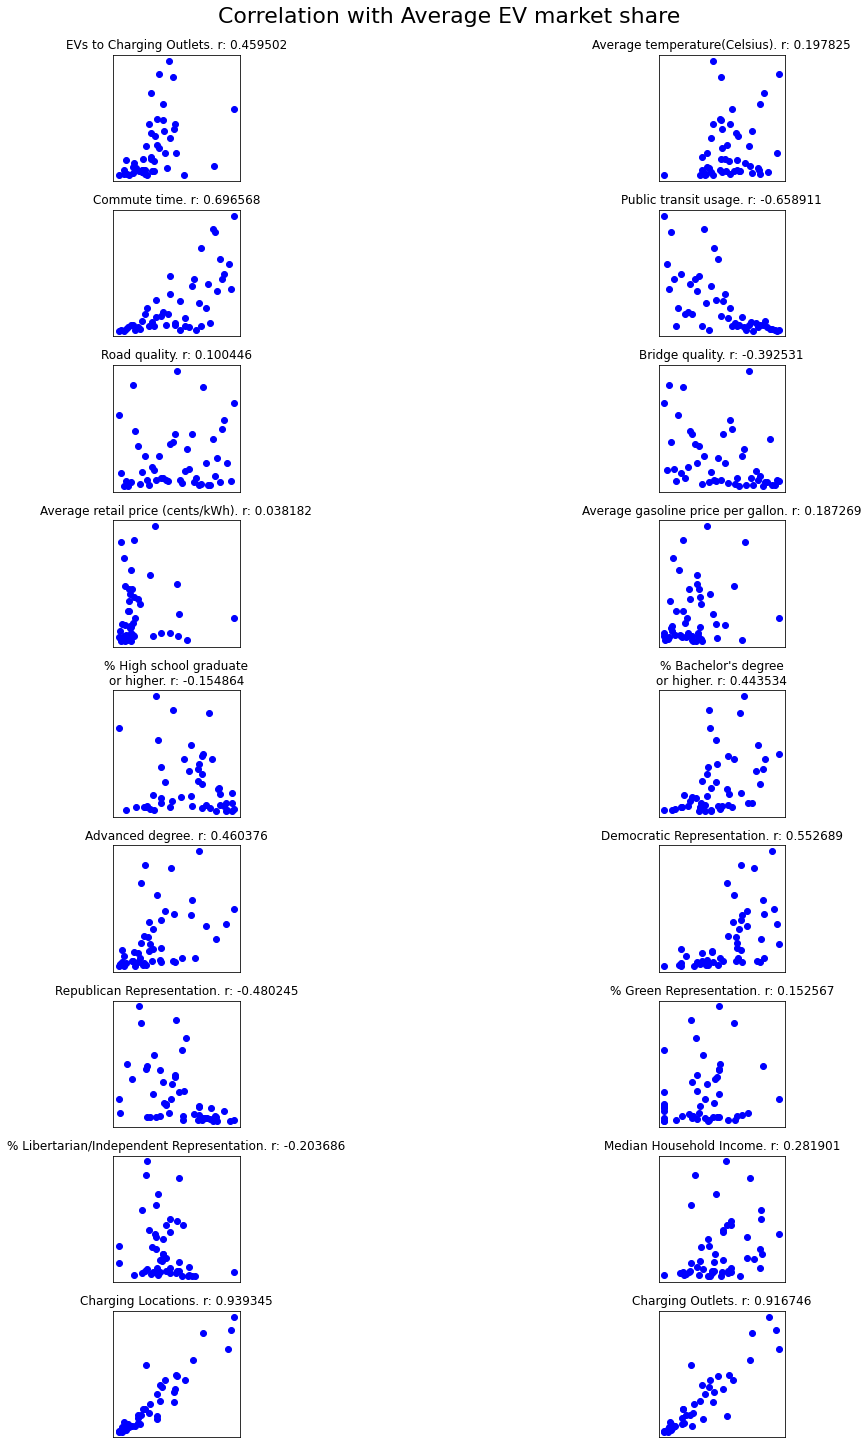

In [106]:
# Adjust columns names
df.rename(columns={"Avg/C": "Average temperature(Celsius)",
                   "Median Household Income\t $": "Median Household Income", 
                   "% Libertarian/ Independent Representation": "% Libertarian/Independent Representation",
                   "Avg gasoline price per gallon": "Average gasoline price per gallon",
                   "COMMUTE TIME": "Commute time",
                   "PUBLIC TRANSIT USAGE": "Public transit usage",
                   "ROAD QUALITY": "Road quality",
                   "BRIDGE QUALITY": "Bridge quality"
                   }, inplace=True)

# Correlation plot between average sales and continuous features
# avg_sales = df['average_sales']
avg_sales = df['Avg % of Total Sales 2015-2018']
# avg_sales.apply(lambda x : (x-avg_sales.mean())/avg_sales.std())
cont_features = ['Average temperature(Celsius)', 'Commute time','Public transit usage','Road quality','Bridge quality','Average retail price (cents/kWh)','Average gasoline price per gallon',
             '% High school graduate\nor higher',"% Bachelor's degree\nor higher",'Advanced degree','Democratic Representation','Republican Representation',
             '% Green Representation','% Libertarian/Independent Representation','Median Household Income','Charging Locations',
             'Charging Outlets','Outlets Per Location','EVs to Charging Outlets']
cont_cols = df.loc[:,cont_features]
cont_cols.columns = cont_features
fig, axs = plt.subplots(9, 2,figsize=(15,20),constrained_layout=True)
fig.suptitle("Correlation with Average EV market share",fontsize=22)
for i in range(18):
    r = i//2
    c = i%2
    # get feature, normalize and plot
    col = cont_cols.iloc[:,i-1].astype(float)
    col=col.apply(lambda x : (x-col.mean())/col.std())
    axs[r, c].plot(col.iloc[:], avg_sales.iloc[:], 'bo')
    # set plot title, showing correlation value
    corr = avg_sales.corr(col)
    axs[r, c].set_title("{}. r: {:2f}".format(col.name,corr))
    # format plot
    axs[r, c].xaxis.set_visible(False)
    axs[r, c].yaxis.set_visible(False)
    x0,x1 = axs[r, c].get_xlim()
    y0,y1 = axs[r, c].get_ylim()
    axs[r, c].set_aspect(abs(x1-x0)/abs(y1-y0))

Commute time, public transit usage, charging locations, charing outlets, democratic representation has |correlation score| > 0.5.  
--> Use for linear regression

Linear Regression score: 0.8781553618321841
Weights:
Commute time: 747.9405626362658
Public transit usage: -1342.633723545503
Charging Locations: 6911.014029240912
Charging Outlets: -957.9777394314004
Democratic Representation: -217.77356455269725
Bias: 716.6074393222129

Test set performance
              true_labels   prediction
State                                 
New Mexico            374   122.545451
Colorado             3954  4046.259527
Nevada               1249  1741.269047
New York             8855  7258.298466
North Dakota           49  -442.939867
Rhode Island          373   784.094689
Oklahoma              964  -216.440730
Tennessee            1034  2210.563573
Florida              7593  6470.131081
Idaho                 275  -248.077845
Mean squared error: 758671.6693308926


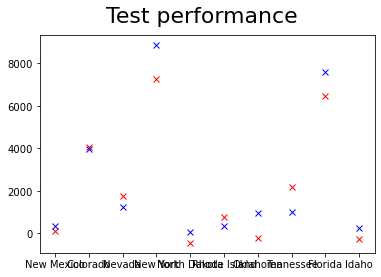

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import statistics as stats
# To try using ev_market_share or avg_sale/population as labels, uncomment the line below
Y = df["average_sales"]
# Y = df['Avg % of Total Sales 2015-2018']
# Y = df["average_sales"]/df["Population"]
X = df.loc[:,['Commute time','Public transit usage','Charging Locations', 'Charging Outlets', 'Democratic Representation']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# scale data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(x_train)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Fit data and print coefficients
lrModel = LinearRegression()
x = X_scaled
y = y_train
lrModel.fit(x,y)
print("Linear Regression score: " + str(lrModel.score(x,y)))
print("Weights:")
for i in range(len(X.columns)):
    print("{}: {}".format(X.columns[i], lrModel.coef_[i]))
print("Bias: " + str(lrModel.intercept_))

x_test_scaled = min_max_scaler.fit_transform(x_test)
pred = lrModel.predict(x_test_scaled)
result = pd.DataFrame({ 'true_labels': y_test, 'prediction': pred }) 
print("\nTest set performance")
print(result)
plt.plot(pred, 'rx', label='prediction')
plt.plot(y_test, 'bx', label='truth')
plt.suptitle("Test performance",fontsize=22)
print("Mean squared error: {}".format(stats.mean([(y_test[i]-pred[i])**2 for i in range(len(pred))])))

# Decision Tree

In [114]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image, display
tree_reg_2 = DecisionTreeRegressor(max_depth=2)
tree_reg_2.fit(x_train,y_train)
export_graphviz( tree_reg_2,
out_file="ev_tree_max_depth_2.dot", feature_names=list(x.columns))

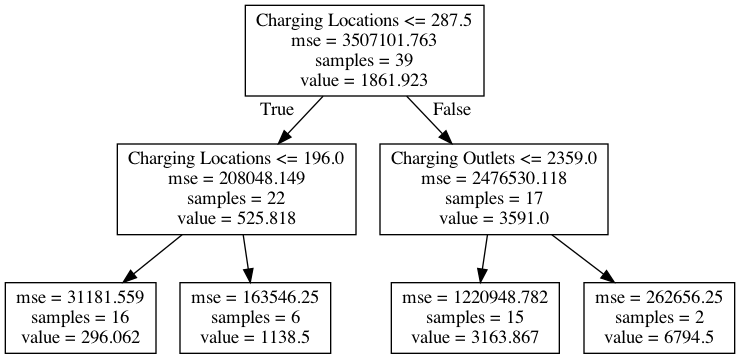

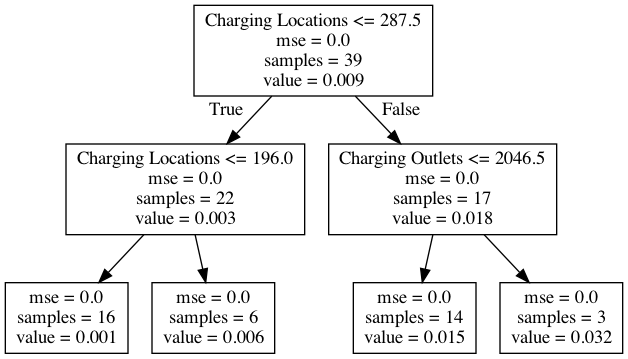


Test set performance
              true_labels   prediction
State                                 
New Mexico            374   296.062500
Colorado             3954  3163.866667
Nevada               1249  1138.500000
New York             8855  6794.500000
North Dakota           49   296.062500
Rhode Island          373   296.062500
Oklahoma              964   296.062500
Tennessee            1034  3163.866667
Florida              7593  6794.500000
Idaho                 275   296.062500
Mean squared error: 1057573.3096753473


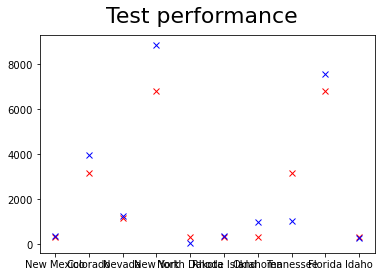

In [122]:
display(Image(filename='ev_tree_2_avg_sales.png'))
display(Image(filename='ev_tree_2_market_share.png'))
print("\nTest set performance")
pred = tree_reg_2.predict(x_test)
result = pd.DataFrame({ 'true_labels': y_test, 'prediction': pred })
print(result)
plt.plot(pred, 'rx', label='prediction')
plt.plot(y_test, 'bx', label='truth')
plt.suptitle("Test performance",fontsize=22)
print("Mean squared error: {}".format(stats.mean([(y_test[i]-pred[i])**2 for i in range(len(pred))])))

In [116]:
tree_reg_3 = DecisionTreeRegressor(max_depth=3)
tree_reg_3.fit(x_train, y_train)
export_graphviz( tree_reg_3,
out_file="ev_tree_max_depth_3.dot", feature_names=list(x.columns))

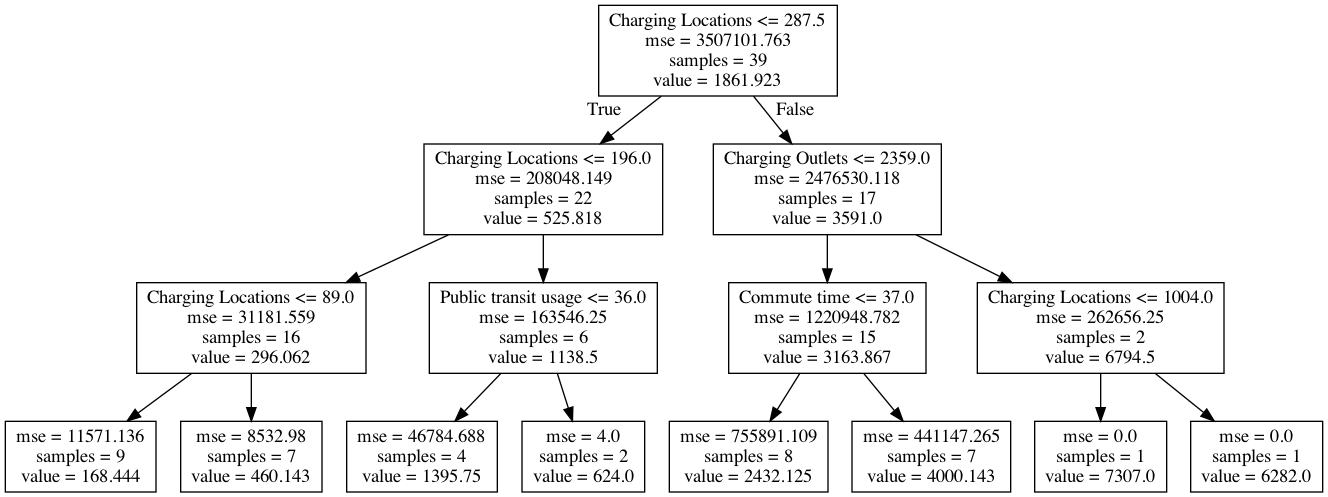

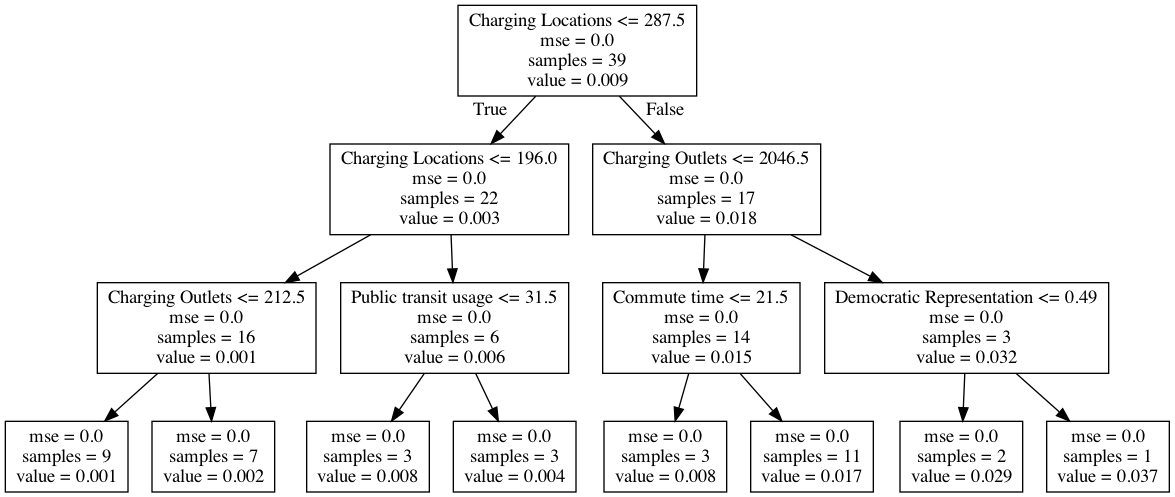


Test set performance
              true_labels   prediction
State                                 
New Mexico            374   168.444444
Colorado             3954  2432.125000
Nevada               1249  1395.750000
New York             8855  6282.000000
North Dakota           49   168.444444
Rhode Island          373   460.142857
Oklahoma              964   168.444444
Tennessee            1034  2432.125000
Florida              7593  6282.000000
Idaho                 275   168.444444
Mean squared error: 1333981.9261424476


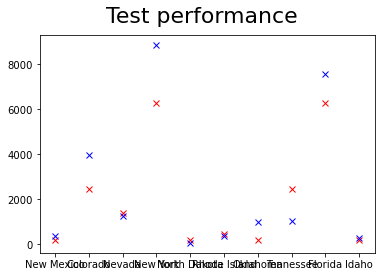

In [123]:
display(Image(filename='ev_tree_3_avg_sales.png'))
display(Image(filename='ev_tree_3_market_share.png'))
print("\nTest set performance")
pred = tree_reg_3.predict(x_test)
result = pd.DataFrame({ 'true_labels': y_test, 'prediction': pred })
print(result)
plt.plot(pred, 'rx', label='prediction')
plt.plot(y_test, 'bx', label='truth')
plt.suptitle("Test performance",fontsize=22)
print("Mean squared error: {}".format(stats.mean([(y_test[i]-pred[i])**2 for i in range(len(pred))])))

# Random forest 

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
dx = pd.read_csv('ECE 143.csv')
dx=dx.drop(index=[4, 8])
dx['average_sales'] = dx.iloc[:,0:4].mean(axis=1).to_frame()
dx['average_sales']=dx['average_sales'].astype(int)
# dx=dx.iloc[:,[4,13,14,15,16,17]]
dx=dx.iloc[:,[34,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]]
dx.columns = ['average_sales', 'Avg/C', 'COMMUTE TIME','PUBLIC TRANSIT USAGE','ROAD QUALITY','BRIDGE QUALITY','Average retail price','Avg gasoline price per gallon',
             'High school graduate or higher','Bachelors degree or higher','Advanced degree','Democratic Representation','Republican Representation',
             'Green Representation','Libertarian/ Independent Representation','Median Household Income','Tax Credit Program','Charging Locations',
             'Charging Outlets','Outlets Per Location','EV Stock','EVs to Charging Outlets']


x, y = dx.iloc[:, 1:].values, dx.iloc[:, 0].values
# x, y = dx.iloc[:, 1:].values, Y.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
np.nan_to_num(x_train)
np.nan_to_num(x_test)
np.nan_to_num(y_train)
np.nan_to_num(y_test)
feat_labels = dx.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [72]:

dx.head()


,average_sales,Avg/C,COMMUTE TIME,PUBLIC TRANSIT USAGE,ROAD QUALITY,BRIDGE QUALITY,Average retail price,Avg gasoline price per gallon,High school graduate or higher,Bachelors degree or higher,...,Republican Representation,Green Representation,Libertarian/ Independent Representation,Median Household Income,Tax Credit Program,Charging Locations,Charging Outlets,Outlets Per Location,EV Stock,EVs to Charging Outlets
0,302,17.1,25.0,43.0,13.0,22.0,9.83,2.54,0.853,0.245,...,0.621,0.0044,0.021,56200,0,115,268,2.33,2487,9.28
1,80,-3.0,8.0,20.0,35.0,36.0,20.22,3.38,0.924,0.290,...,0.513,0.0180,0.059,78394,0,16,26,1.62,534,20.54
2,2299,15.7,32.0,21.0,24.0,4.0,10.52,2.93,0.865,0.284,...,0.487,0.0133,0.041,70674,1,454,1223,2.69,18129,14.82
3,133,15.8,10.0,47.0,36.0,17.0,8.22,2.58,0.856,0.220,...,0.606,0.0084,0.026,54539,0,72,196,2.72,1194,6.09
5,2921,7.3,33.0,14.0,32.0,13.0,10.17,2.81,0.911,0.394,...,0.433,0.0138,0.052,72499,1,692,1857,2.68,19738,10.63


importance： [0.04897226 0.04887659 0.04897652 0.0527415  0.0565578  0.04689592
 0.0495685  0.04848422 0.04875726 0.04723154 0.04781173 0.04690075
 0.04778965 0.04576478 0.04519448 0.01322681 0.04662998 0.04659703
 0.05768894 0.05404529 0.05128844]
 1) Outlets Per Location           0.057689
 2) BRIDGE QUALITY                 0.056558
 3) EV Stock                       0.054045
 4) ROAD QUALITY                   0.052742
 5) EVs to Charging Outlets        0.051288
 6) Avg gasoline price per gallon  0.049569
 7) PUBLIC TRANSIT USAGE           0.048977
 8) Avg/C                          0.048972
 9) COMMUTE TIME                   0.048877
10) Bachelors degree or higher     0.048757
11) High school graduate or higher 0.048484
12) Democratic Representation      0.047812
13) Green Representation           0.047790
14) Advanced degree                0.047232
15) Republican Representation      0.046901
16) Average retail price           0.046896
17) Charging Locations             0.046630
18) 

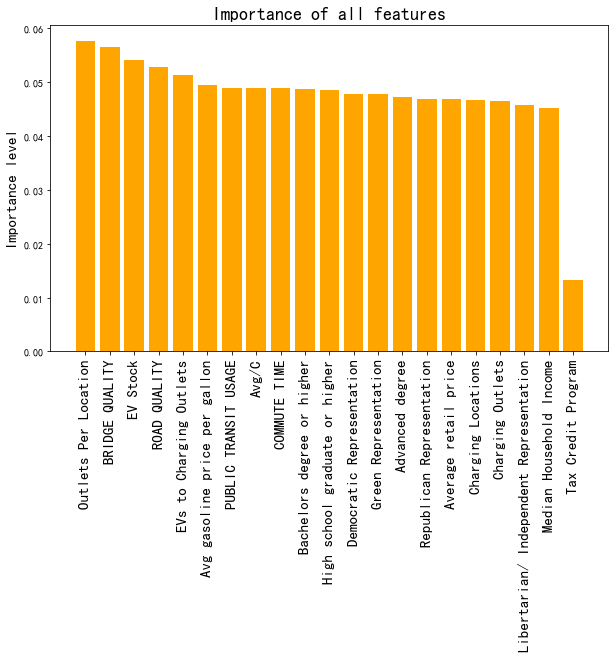

In [73]:
importances = forest.feature_importances_
print("importance：", importances)

x_columns = dx.columns[1:]
indices = np.argsort(importances)[::-1]
x_columns_indices = []
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    x_columns_indices.append(feat_labels[indices[f]])
plt.figure(figsize=(10, 6))
plt.title("Importance of all features", fontsize=18)
plt.ylabel("Importance level", fontsize=15, rotation=90)
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
for i in range(x_columns.shape[0]):
    plt.bar(i, importances[indices[i]], color='orange', align='center')
    plt.xticks(np.arange(x_columns.shape[0]), x_columns_indices, rotation=90, fontsize=15)
plt.show()